In [1]:
# system tools
import os

# pytorch
import torch
import torch.nn as nn

# data processing
import pandas as pd
import numpy as np

# huggingface datasets
from datasets import load_dataset

# scikit learn tools
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# plotting tools
import matplotlib.pyplot as plt


In [2]:
class Model(nn.Module):
    def __init__(self, n_input_features):
        super().__init__()
        self.linear1 = nn.Linear(n_input_features, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 1)

    def forward(self, x):
        leaky_relu = nn.LeakyReLU(0.2)
        # Linear -> ReLU
        x = self.linear1(x)
        x = leaky_relu(x)
        # Linear -> ReLU
        x = self.linear2(x)
        x = leaky_relu(x)
        # Linear -> Sigmoid
        x = self.linear3(x)
        y_pred = torch.sigmoid(x)
        return y_pred

In [3]:
# load the sst2 dataset
dataset = load_dataset("rotten_tomatoes")

Found cached dataset rotten_tomatoes (/home/coder/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# select the train split
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

In [5]:
# vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                            #lowercase=True, 
                            #stop_words="english", 
                            max_df=0.9, 
                            min_df=0.1,
                            max_features=500)

In [6]:
# vectorized training data -> to tensors
train_vect = vectorizer.fit_transform(train["text"])
train_vect = torch.tensor(train_vect.toarray(), dtype=torch.float)

# labels
train_label = torch.tensor(list(train["label"]), dtype=torch.float)
train_label = train_label.view(train_label.shape[0], 1)

In [7]:
# vectorized validation data -> to tensors
val_vect = vectorizer.transform(val["text"])
val_vect = torch.tensor(val_vect.toarray(), dtype=torch.float)

# labels
val_label = torch.tensor(list(val["label"]), dtype=torch.float)
val_label = val_label.view(val_label.shape[0], 1)

In [8]:
# vectorized test data -> to tensors
test_vect = vectorizer.transform(test["text"])
test_vect = torch.tensor(test_vect.toarray(), dtype=torch.float)

# labels
test_label = torch.tensor(list(test["label"]), dtype=torch.float)
test_label = test_label.view(test_label.shape[0], 1)

In [9]:
# initialize model
n_samples, n_features = train_vect.shape
model = Model(n_input_features=n_features)

# define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=1e-4)

In [10]:
# for plotting
train_loss_history = []
val_loss_history = []

In [11]:

# train
epochs = 1000
print("[INFO:] Training classifier...")

# loop for epochs
for epoch in range(epochs):
    
    # forward
    y_hat = model(train_vect)

    # backward
    loss = criterion(y_hat, train_label)
    train_loss_history.append(loss)

    # backpropagation
    loss.backward()
    
    # take step, reset
    optimizer.step()
    optimizer.zero_grad()
    
    # Validation Loop 
    with torch.no_grad(): 
        # set to eval mode
        model.eval() 

        # make predictions
        predicted_outputs = model(val_vect) 

        # metrics
        val_loss = criterion(predicted_outputs, val_label) 

        # append
        val_loss_history.append(val_loss) 

    # some print to see that it is running
    if (epoch + 1) % 100 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f}")

print("[INFO:] Finished traning!")

[INFO:] Training classifier...
epoch: 100, loss = 0.6917
epoch: 200, loss = 0.6882
epoch: 300, loss = 0.6836
epoch: 400, loss = 0.6792
epoch: 500, loss = 0.6772
epoch: 600, loss = 0.6760
epoch: 700, loss = 0.6751
epoch: 800, loss = 0.6742
epoch: 900, loss = 0.6732
epoch: 1000, loss = 0.6721
[INFO:] Finished traning!


In [12]:
# Plot
predicted = model(test_vect).detach().numpy()
print(classification_report(test_label, 
                            np.where(predicted > 0.5, 1, 0),
                            target_names = ["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.57      0.56      0.57       533
    Positive       0.57      0.58      0.57       533

    accuracy                           0.57      1066
   macro avg       0.57      0.57      0.57      1066
weighted avg       0.57      0.57      0.57      1066



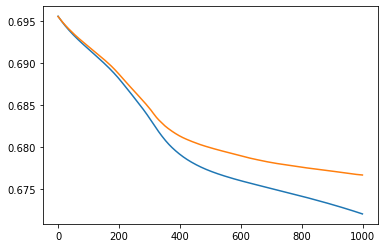

In [13]:
train_loss = [val.item() for val in train_loss_history]
val_loss = [val.item() for val in val_loss_history]

fig, ax = plt.subplots()
ax.plot(train_loss)
ax.plot(val_loss)